<a href="https://colab.research.google.com/github/javierdealba/inmobibot/blob/main/Avence_3_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avence 3. Baseline
Javier de Alba Pérez

A01226046

Equipo 26

El algoritmo seleccionado para el chatbot de la inmobiliaria Levante es Retrieval-Augmented Generation (RAG). Este enfoque es particularmente adecuado para el problema por las siguientes razones:



*   **Tipo de Datos**: Estos son no estructurados: La mayor parte de los datos manejados, como descripciones de propiedades y consultas de usuarios, son no estructurados y en formato de texto. RAG es eficiente en la gestión y procesamiento de este tipo de datos, permitiendo generar respuestas coherentes y contextuales basadas en textos recuperados.
*   **Características Relevantes**: Recuperación y Generación: RAG combina la capacidad de recuperación de información con la generación de texto. Esto significa que puede buscar información específica en una base de datos extensa y luego generar una respuesta bien formada basada en esa información, lo cual es crucial para atender consultas complejas de los clientes.
*   **Escalabilidad y Flexibilidad**: los RAG pueden escalarse fácilmente para manejar más datos y realizar consultas de mayor complejidad. Además, puede adaptarse a diferentes dominios y tipos de consultas, lo que es beneficioso para una inmobiliaria que maneja diversas propiedades y tipos de consultas.
*   **Interpretabilidad**: En este caso la interpretabilidad es importante, la prioridad principal es la precisión y relevancia de las respuestas. RAG proporciona una combinación adecuada, permitiendo a los usuarios obtener respuestas precisas sin necesidad de entender completamente el proceso subyacente.

## Instalaciones

Aquí se instalan los paquetes necesarios para el funcionamiento del código

In [1]:
! pip install langchain langchain_community langchain_core langchain_openai fastembed chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

## Importaciones y funciones

Se importan las librerías y se extrae la API key de una variable de entorno.

In [6]:
import os
import pandas as pd

from typing import List
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

openai_api_key = os.getenv("OPENAI_API_KEY")

Se definen las funciones a utilizar en el cuerpo principal del código.

In [8]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Loads data from a CSV file.

    This function reads a CSV file from the specified file path and
    returns the data as a pandas DataFrame.

    Parameters:
    file_path (str): The path to the CSV file.

    Returns:
    pd.DataFrame: A DataFrame containing the loaded data.
    """
    data = pd.read_csv(file_path)
    return data

def load_csv_with_loader():
    """
    Loads data from a CSV file using a CSVLoader.

    Returns:
        Any: The data loaded from the CSV file.
    """
    loader = CSVLoader(file_path="docs.csv", source_column="page_content", encoding="utf8")
    data = loader.load()

    return data


def create_documents(data: pd.DataFrame, data_columns: List[str]) -> pd.DataFrame:
    """
    Creates a new DataFrame containing concatenated string representations of
    selected columns from the input data, then saves it to a CSV file.

    Args:
        data (DataFrame): The input DataFrame containing the data.
        data_columns (List[str]): A list of column names from the input DataFrame to be included in the documents.

    Returns:
        DataFrame: A new DataFrame containing the concatenated documents.
    """
    data["page_content"] = ""
    for column in data_columns:
        data["page_content"] += f"{column}: " + data[column].astype(str) + "\n"

    docs = data[["page_content"]]
    docs.to_csv("docs.csv")

    return docs


def get_retriever(docs: pd.DataFrame):
    """
    Create a retriever for a given set of documents.

    Args:
        docs (pd.DataFrame): The DataFrame containing the documents.

    Returns:
        Retriever: The retriever object.
    """
    current_path = os.getcwd()
    data_path = os.path.join(current_path, "data/embeddings_vector_store")

    embedding_model = FastEmbedEmbeddings()
    vector_store = Chroma.from_documents(
        documents = docs,
        embedding = embedding_model,
        persist_directory = data_path,
    )

    retriever = vector_store.as_retriever(
        search_type = "similarity_score_threshold",
        search_kwargs = {
            "k": 20,
            "score_threshold": 0.05,
        },
    )
    print(retriever)

    return retriever


def generate_response(retriever, input_line: str) -> str:
    """
    Generate a response to an input question using the given retriever.

    Args:
        retriever: The retriever component used for document retrieval.
        input_line (str): The input question or query.

    Returns:
        str: The response to the input question.
    """
    template = """
    Compórtate como un excelente vendedor inmobiliario, por lo que las respuestas deben ser
    Contesta la pregunta que se hace basandote unicamente en el contexto que se proporciona.

    <context>
    {context}
    </context>

    Pregunta: {input}
    """
    model = ChatOpenAI(
        temperature=0.7, openai_api_key=openai_api_key, model="gpt-3.5-turbo"
    )
    prompt = ChatPromptTemplate.from_template(template)


    document_chain = create_stuff_documents_chain(model, prompt)
    retrieval_chain = create_retrieval_chain(retriever, document_chain)
    response = retrieval_chain.invoke({"input": input_line})

    return response

## Función principal (main)

Aquí se entrena el modelo RAG y se hace el llamado a la primer pregunta de prueba.

In [9]:
# Load the data
data = load_data("listado_propiedades.csv")
data_columns = data.columns.tolist()
docs = create_documents(data, data_columns)
docs = load_csv_with_loader()


# Create documents from the data
# ids, docs = create_documents(data, data_columns)

retriever = get_retriever(docs)

input_line = "Qué propiedades tienes en Capital Norte y que caracteristicas tienen?"
response = generate_response(retriever, input_line)
print(response["answer"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

model_optimized.onnx:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

tags=['Chroma', 'FastEmbedEmbeddings'] vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7bcb41fafeb0> search_type='similarity_score_threshold' search_kwargs={'k': 20, 'score_threshold': 0.05}
Tenemos tres propiedades en Capital Norte:

1. Casa en Capital Norte Coto Sienna:
   - Dirección: Paseo de la Cantera 702 Casa 28, Col. Sendas residencial, Zapopan, Jalisco
   - Características: 3 niveles, 3 recámaras, 2 baños completos, 1 medio baño, 2 estacionamientos, terreno de 112 m2, construcción de 163 m2, precio de $3,900,000, estado excelente.

2. Casa en Capital Norte Coto Carrara:
   - Dirección: Avenida Paseo de la Cantera 765 107, Col. Sendas residencial, Zapopan, Jalisco
   - Características: 3 niveles, 4 recámaras, 3 baños completos, 1 medio baño, cuarto de servicio, 2 estacionamientos, terreno de 114.7 m2, construcción de 175.24 m2, precio de $3,950,000, estado excelente.

3. Casa en Capital Norte Coto Carrara:
   - Dirección: Avenida Paseo de a Cantera 765 C

## Análisis

In [10]:
print(f"Pregunta: {input_line}")
print(f"\nRespuesta:\n{response['answer']}")

Pregunta: Qué propiedades tienes en Capital Norte y que caracteristicas tienen?

Respuesta:
Tenemos tres propiedades en Capital Norte:

1. Casa en Capital Norte Coto Sienna:
   - Dirección: Paseo de la Cantera 702 Casa 28, Col. Sendas residencial, Zapopan, Jalisco
   - Características: 3 niveles, 3 recámaras, 2 baños completos, 1 medio baño, 2 estacionamientos, terreno de 112 m2, construcción de 163 m2, precio de $3,900,000, estado excelente.

2. Casa en Capital Norte Coto Carrara:
   - Dirección: Avenida Paseo de la Cantera 765 107, Col. Sendas residencial, Zapopan, Jalisco
   - Características: 3 niveles, 4 recámaras, 3 baños completos, 1 medio baño, cuarto de servicio, 2 estacionamientos, terreno de 114.7 m2, construcción de 175.24 m2, precio de $3,950,000, estado excelente.

3. Casa en Capital Norte Coto Carrara:
   - Dirección: Avenida Paseo de a Cantera 765 Coto Carrara 193, Col. Valle imperial, Zapopan, Jalisco
   - Características: 3 niveles, 4 recámaras, 5 baños completos, cua

### Características importantes
En los avances anteriores, se hizo un PCA para un caso hipotético de predicción de precios, según las variables. En este caso, todas las variables fueron seleccionadas para brindar más información sobre las propiedades, así como lo haría un asesor que trabaje en la inmobiliaria, y se hizo de manera manual esta base de datos con la información requerida. Inicialmente se contaba con otros datos, sin embargo estos no iban a responder las dudas que un cliente pudiese tener, por lo que se seleccionaron cuidadosamente los nuevos datos y así se hizo el modelo.

De la misma manera, el modelo lleva embeddings en las características, para poder recuperar esa información si es que se le pregunta.

### Evaluación y métricas

La mejor manera que se puede evaluar de momento es hacer un examen al modelo sobre las propiedades. Se le harán 10 preguntas y se utilizará la precisión como métrica de evaluación. La fórmula de precisión es la siguiente:

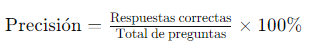



In [18]:
questions = [
    "¿Qué propiedades están disponibles en Capital Norte?",
    "¿Cuáles son las características de la propiedad ubicada en Toren54?",
    "¿Qué características tienen las propiedades en Santa Cruz de la Loma?",
    "¿Cuál es el rango de precios de las propiedades en Capital Norte?",
    "Quiero recibir información sobre la plaza comercial en venta en golfo de cortés.",
    "¿Qué amenidades están disponibles en las propiedades de Altavista?",
    "Busco una propiedad con un precio alrededor de $2,000,000 de pesos con 3 recámaras. ¿Qué opciones tienes?",
    "¿En qué zonas tienes terrenos con un tamaño mayor a 200 metros cuadrados?",
    "¿En dónde tienes departamentos en venta?",
    "¿Cuál es el mejor local comercial que tienes?",
]
responses = []
for i, q in enumerate(questions):
  response = generate_response(retriever, q)
  responses.append(response)
  print(f"Pregunta {i+1}: {q}")
  print(f"\nRespuesta:\n{response['answer']}\n\n")

Pregunta 1: ¿Qué propiedades están disponibles en Capital Norte?

Respuesta:
Las propiedades disponibles en Capital Norte son las siguientes:
1. Capital Norte Coto Sienna
2. Capital Norte Coto Sivec 73
3. Capital Norte Coto Carrara
4. Capital Norte Coto Carrara


Pregunta 2: ¿Cuáles son las características de la propiedad ubicada en Toren54?

Respuesta:
La propiedad ubicada en Toren 54 es un departamento de 2 niveles, con 1 recámara, 1 baño completo, 1 medio baño, 1 estacionamiento, con un terreno y construcción de 73.82 metros cuadrados, en excelente estado y sin cuota de mantenimiento.


Pregunta 3: ¿Qué características tienen las propiedades en Santa Cruz de la Loma?

Respuesta:
Las propiedades en Santa Cruz de la Loma son terrenos, no están amuebladas, tienen uso de suelo habitacional, el relieve es plano, se encuentran en excelente estado y no tienen gravamen.


Pregunta 4: ¿Cuál es el rango de precios de las propiedades en Capital Norte?

Respuesta:
El rango de precios de las pro

Juzgando con estas preguntas, las respuestas correctas son 1, 2

La pregunta tres no la calificaría necesariamente como correcta, ya que hago una pregunta de propiedades en plural, y me responde igual, aunque solo hay una propiedad en dicha ubicación.

La pregunta 8 plantea una pregunta para que se filtran los terrenos mayores a 200 metros cuadrados, sin embargo se incluye una propiedad que tiene menos de ese metraje, y falta una propiedad que apenas pasa los 200 metros.

Estos dos casos en particular deben de ser evaluados, para ver cómo se puede mejorar el desempeño del modelo. Adicionalmente, se espera mejorar ciertos detalles, ya que al ser generalizada la base de datos, el modelo interpreta que una plaza comercial tiene "habitaciones" en lugar de locales. Se debe pulir esto un poco más.

En cuanto al subentrenamiento, con el análisis cualitativo de las preguntas se puede evaluar que no hay un tema importante de subentrenamiento. En cuanto al sobreentrenamiento, es muy poco probable que pudiera afectar el rendimiento de este modelo, ya que al entrenar se le dice explicitamente al modelo que se base únicamentente en el contexto proporcionado.